# Homework 4 - Deep Learning

## Задание 8

Обучите модель из двух сверточных слоев на датасете `CIFAR10`, добейтесь значения метрики `Accuracy` в 70% на тестовой выборке. Ограничения касаются только количества сверточных слоев в архитектуре модели, можно использовать любые клевые штуки, что мы прошли на занятии. Вам нужно сдать код с функцией, которая возвращает модель, назовите эту функцию `create_simple_conv_cifar`. Она не принимает аргументов и возвращает модель. Также сдайте предсказание для тестовой выборки датасета `CIFAR10`, воспользуйтесь функцией `predict` из предыдущего задания. Воспользуйтесь `torch.save` для записи тензора с результатом предсказания на диск.

### Импорт библиотек

In [19]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
from IPython.display import clear_output
from PIL import Image
from matplotlib import cm
from time import perf_counter
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision.datasets import CIFAR10
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

import importlib
task5 = importlib.import_module("5 - Architects")
task4 = importlib.import_module("4 - RegularizeConvNet")
task3 = importlib.import_module("3 - ConvNets")
task2 = importlib.import_module("2 - NeuralOptim")

%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')

plt.rc('font', size=30)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Импорт датасета

Прежде чем создавать тренировочные и тестовые батчи датасета, для начала определим преобразования для него. Для этого нам может пригодиться знание среднего и стандартного отклонения по датасету

In [3]:
cifar_train = CIFAR10(
    "../../datasets/cifar",
    train=True,
    download=True,
    transform=T.ToTensor()  # чтобы переводился сразу в тензорный объект
)

Files already downloaded and verified


In [4]:
means = (cifar_train.data / 255).mean(axis=(0, 1, 2)) # делим на 255, чтобы значения признаков лежали в [0, 1]
std = (cifar_train.data / 255).std(axis=(0, 1, 2))


In [5]:
# применим функцию с преобразованиями

def get_augmentations(means: float, std: float, train: bool = True) -> T.Compose:
    if train:
        return T.Compose(
            [
                T.RandAugment(),
                T.RandAugment(),
                T.ToTensor(),
                T.Normalize(mean=means, std=std)
            ]
        )
    else:
        return T.Compose(
            [
                T.ToTensor(),
                T.Normalize(mean=means, std=std)
            ]
        )


In [6]:
# создадим loader для трейна и теста

train_dataset = CIFAR10(
    "../../datasets/cifar",
    train=True,
    download=False,
    transform=get_augmentations(means=means, std=std, train=True) 
)

test_dataset = CIFAR10(
    "../../datasets/cifar",
    train=False,
    download=True,
    transform=get_augmentations(means=means, std=std, train=False)
)


Files already downloaded and verified


In [35]:
len(test_dataset)


3

In [7]:
train_loader = DataLoader(train_dataset, batch_size=128,
                          shuffle=True, 
                          num_workers=8, 
                        #   pin_memory=True
                          )
test_loader = DataLoader(test_dataset, batch_size=128,
                          shuffle=False, 
                          num_workers=8, 
                        #   pin_memory=True
                          )

### Соберем служебные функции

В этом разделе подготовим функции, которые будут обучать модель, замерять качество модели, делать предсказания, и, наконец, визуализировать обучение модели

In [8]:
# функция обучения
def train(model: nn.Module, data_loader: DataLoader, optimizer: torch.optim.Optimizer, loss_fn):
    model.to(device)
    model.train()
    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(data_loader, desc='Training'):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()  # zeroing gradients
        output = model(x)  # forward pass
        loss = loss_fn(output, y)  # count loss
        total_loss += loss.item()  # writing current loss
        loss.backward()  # backward pass
        # print(round(loss.item(), 5))  # print current loss
        optimizer.step()  # optimization step
        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()
    total_loss /= len(data_loader)
    accuracy = correct / total

    return total_loss, accuracy


In [9]:
# функция оценки качества
@torch.inference_mode()
def evaluate(model: nn.Module, loader: DataLoader) -> tuple:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)
        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [10]:
# Функция предсказания
@torch.inference_mode()
def predict(model: nn.Module, loader: DataLoader, device: torch.device):
    model.to(device)
    model.eval()
    predictions = []
    for x, y in tqdm(loader, desc='Prediction'):
        x, y = x.to(device), y.to(device)
        output = model(x)
        predictions.append(torch.argmax(output, axis=1))
    return torch.concat(predictions)


In [11]:
# функция визуализации
def plot_stats(
    train_loss: list,
    valid_loss: list,
    train_accuracy: list,
    valid_accuracy: list,
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()


In [12]:
# функция для прогона обучения и валидации для нескольких эпох

def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_loader, optimizer, loss_fn)
        valid_loss, valid_accuracy = evaluate(model, test_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

### Соберем модель

Основное требование к модели - 2 сверточных слоя

In [12]:
def create_simple_conv_cifar():
    return nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16,
                  kernel_size=3, padding=1),  # 32 x 32 x 16
        nn.ReLU(),

        nn.MaxPool2d(2),  # 16 x 16 x 16

        nn.Conv2d(in_channels=16, out_channels=32,
                  kernel_size=3, padding=1),  # 16 x 16 x 32
        nn.ReLU(),

        nn.MaxPool2d(2),  # 8 x 8 x 32

        nn.Flatten(),

        nn.Linear(8 * 8 * 32, 1024),
        nn.ReLU(),
        nn.Linear(1024, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

In [13]:
# Создаем модель
model = create_simple_conv_cifar()

# Зададим функцию ошибки и оптимизатор
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)



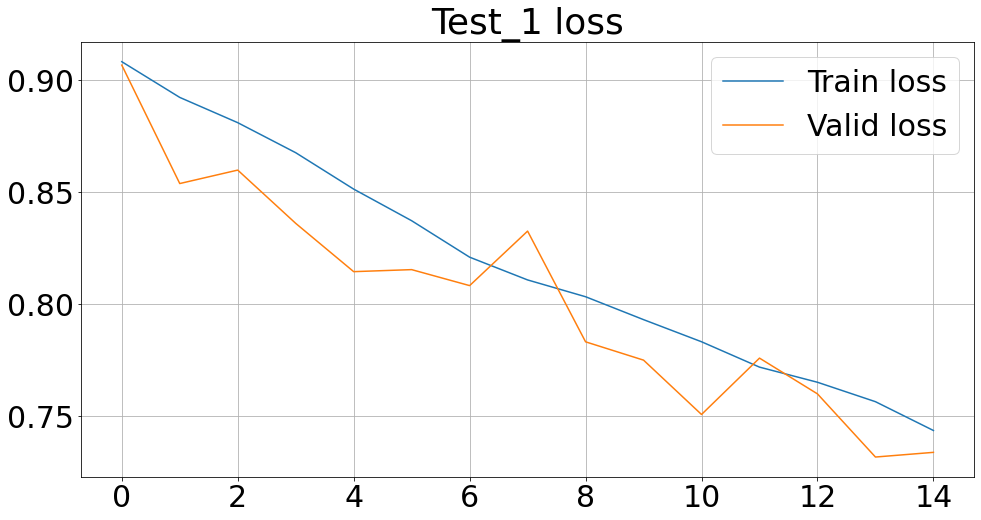

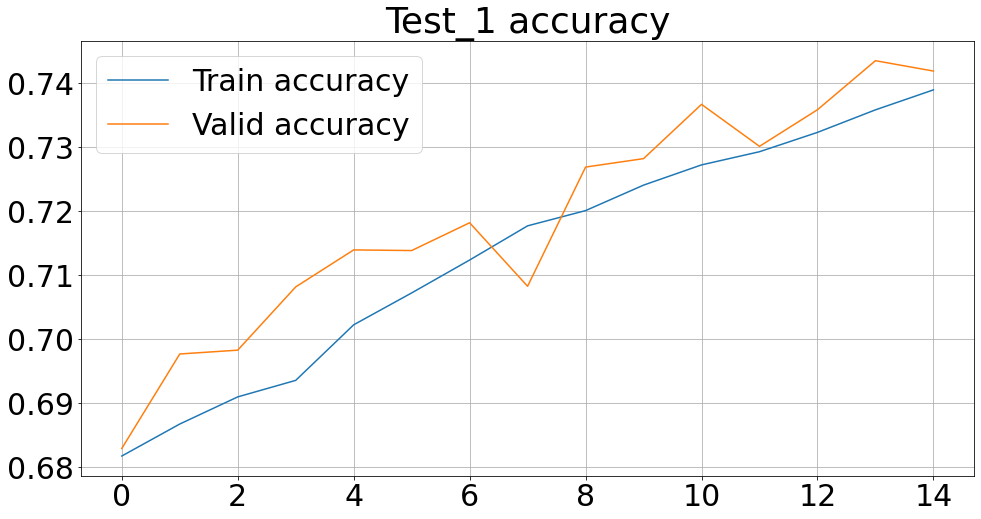

In [45]:
whole_train_valid_cycle(model, 15, 'Test_1')


In [88]:
preds = predict(model, test_loader, device)

predicting: 100%|██████████| 79/79 [00:54<00:00,  1.44it/s] 


In [97]:
# сохраним предсказания на диск
torch.save(preds, 'cifar_simple.pkl')

In [95]:
preds, preds.shape

(tensor([3, 8, 8,  ..., 5, 1, 7], device='cuda:0'), torch.Size([10000]))

## Задание 10
Обучите любую модель на датасете `CIFAR10`, добейтесь значения метрики `Accuracy` в 90% на тестовой выборке. Вам нужно сдать код с функцией, которая возвращает модель, назовите эту функцию `create_advanced_conv_cifar`. Она не принимает аргументов и возвращает модель. Также сдайте предсказание для тестовой выборки датасета `CIFAR10`, воспользуйтесь функцией `predict_tta` из предыдущего задания (сравните результаты с помощью обычного `predict` и `predict_tta`, оцените какой прирост качества дает последняя), для того, чтобы использовать `predict_tta` нужно создать отдельно тестовый даталоадер с аугментациями. Воспользуйтесь `torch.save` для записи тензора с результатом предсказания на диск.

### Создаем новую функцию предсказания

In [13]:
@torch.inference_mode()
def predict_tta(model: nn.Module, loader: DataLoader, device: torch.device, iterations: int = 2):
    model.to(device)
    model.eval()
    iter_list = []
    outputs_list = []
    for i in range(iterations):
        for x, _ in loader:
            x = x.to(device)
            output = model(x)
            outputs_list.append(output)
        iter_list.append(torch.concat(outputs_list))
        outputs_list = []
    big_tensor = torch.stack(iter_list, dim=2)
    big_tensor = torch.mean(big_tensor, dim=2)
    return torch.argmax(big_tensor, axis=1)




### Создаем новый тестовый loader

In [14]:
test_transform = T.Compose(
    [
        T.AutoAugment(T.AutoAugmentPolicy.CIFAR10),
        T.ToTensor(),
        T.Normalize(mean=means, std=std)
    ]
)

test_dataset_tta = CIFAR10(
    "../../datasets/cifar",
    train=False,
    download=True,
    transform=test_transform
)

test_loader_tta = DataLoader(test_dataset, batch_size=128,
                             shuffle=False, num_workers=8, pin_memory=True)

Files already downloaded and verified


### Создаем новую модель

Модель может быть произвольной

In [30]:
def create_advanced_conv_cifar():
    return nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32,
                  kernel_size=3, padding=1),  # 32 x 32 x 32
        nn.BatchNorm2d(32),
        nn.ReLU(),

        nn.Conv2d(in_channels=32, out_channels=32,
                  kernel_size=3, padding=1),  # 32 x 32 x 32
        nn.BatchNorm2d(32),
        nn.ReLU(),

        nn.MaxPool2d(2),  # 16 x 16 x 32
        nn.Dropout2d(p=0.2),

        nn.Conv2d(in_channels=32, out_channels=64,
                  kernel_size=3, padding=1),  # 16 x 16 x 64
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.Conv2d(in_channels=64, out_channels=64,
                  kernel_size=3, padding=1),  # 16 x 16 x 64
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.MaxPool2d(2),  # 8 x 8 x 32
        nn.Dropout2d(p=0.2),

        nn.Conv2d(in_channels=64, out_channels=128,
                  kernel_size=3, padding=1),  # 8 x 8 x 128
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.Conv2d(in_channels=128, out_channels=128,
                  kernel_size=3, padding=1),  # 8 x 8 x 128
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.MaxPool2d(2),  # 4 x 4 x 128
        nn.Dropout2d(p=0.2),

        nn.Flatten(),

        nn.Linear(4 * 4 * 128, 512),
        nn.BatchNorm1d(512),
        nn.Dropout(p=0.2),
        nn.ReLU(),
        nn.Linear(512, 10)
    )


In [40]:
# создаем модель
from torch.optim.lr_scheduler import StepLR

new_model = create_advanced_conv_cifar()

# Зададим функцию ошибки и оптимизатор
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(new_model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=6)


In [41]:
def whole_train_valid_cycle_with_scheduler(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []
    scheduler.last_epoch = num_epochs

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_loader, optimizer, loss_fn)
        valid_loss, valid_accuracy = evaluate(model, test_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

        scheduler.step()


In [ ]:
whole_train_valid_cycle_with_scheduler(new_model, 20, 'Test_2')


Мы пробовали обучать нашу модель с помощью постепенного понижения шага градиента. Хотя шаг выбран достаточно большим, а количество эпох - больше 40, наша модель не смогла обучиться до качества выше 86%.
Попробуем применить ускоренный планировщик градиента `OneCycleLR`

In [76]:
from torch.optim.lr_scheduler import OneCycleLR



model_3 = create_advanced_conv_cifar()

# Зададим функцию ошибки и оптимизатор
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model_3.parameters())
oc_scheduler = OneCycleLR(optimizer=optimizer, max_lr=0.01,
                          epochs=80, steps_per_epoch=len(train_loader))


Так как этот планировщик работает с батчами внутри тренировочного цикла, нам надо переписать функцию train

In [77]:
def whole_train_valid_cycle_with_oc_scheduler(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        model.to(device)
        model.train()
        train_loss = 0
        total = 0
        correct = 0

        for x, y in tqdm(train_loader, desc='Training'):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()  # zeroing gradients
            output = model(x)  # forward pass
            loss = loss_fn(output, y)  # count loss
            train_loss += loss.item()  # writing current loss
            loss.backward()  # backward pass
            # print(round(loss.item(), 5))  # print current loss
            optimizer.step()  # optimization step
            _, y_pred = torch.max(output, 1)
            total += y.size(0)
            correct += (y_pred == y).sum().item()
            oc_scheduler.step() # adding scheduler in batch cycle
        train_loss /= len(train_loader)
        train_accuracy = correct / total
        
        valid_loss, valid_accuracy = evaluate(model, test_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )


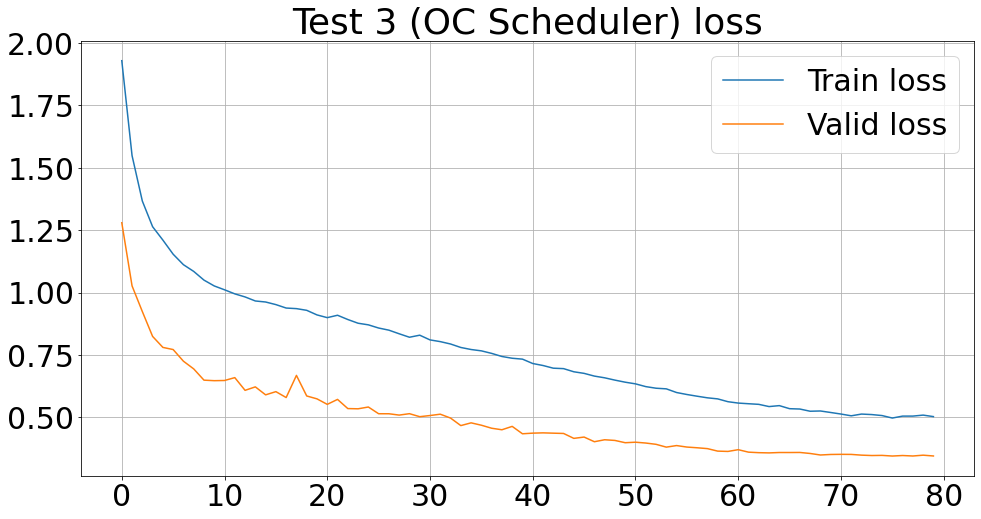

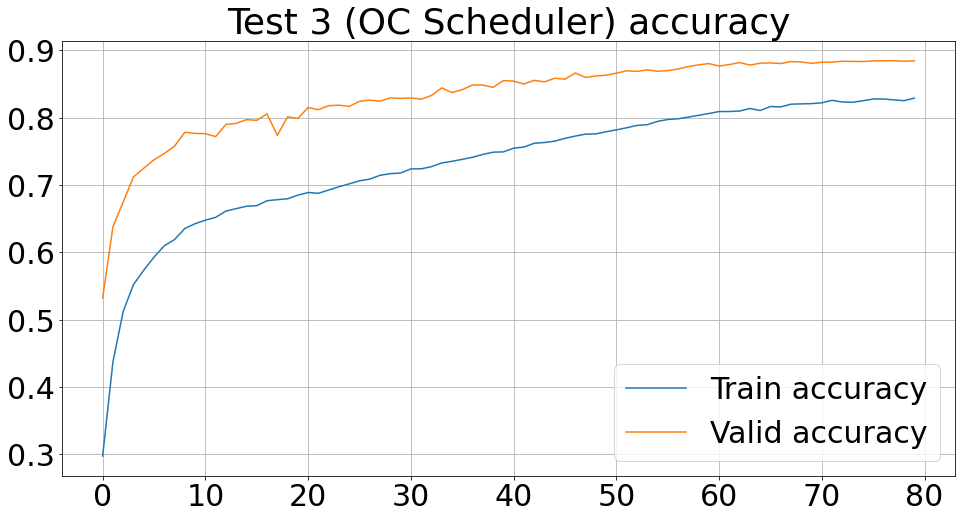

In [78]:
whole_train_valid_cycle_with_oc_scheduler(model_3, num_epochs=80, title='Test 3 (OC Scheduler)')


Достигли 88%. Хорошо, но мало, а также наша нейросеть долго обучается, и быстро выходит на плато.  
Добавим эпох и поменяем планировщик

In [82]:
# создаем модель
from torch.optim.lr_scheduler import ReduceLROnPlateau

new_model_4 = create_advanced_conv_cifar()

# Зададим функцию ошибки и оптимизатор
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(new_model_4.parameters(), lr=1e-2)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8)


In [15]:
def whole_train_valid_cycle_with_plateau_scheduler(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []
    scheduler.last_epoch = num_epochs

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(
            model, train_loader, optimizer, loss_fn)
        valid_loss, valid_accuracy = evaluate(model, test_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

        scheduler.step(metrics=valid_loss)


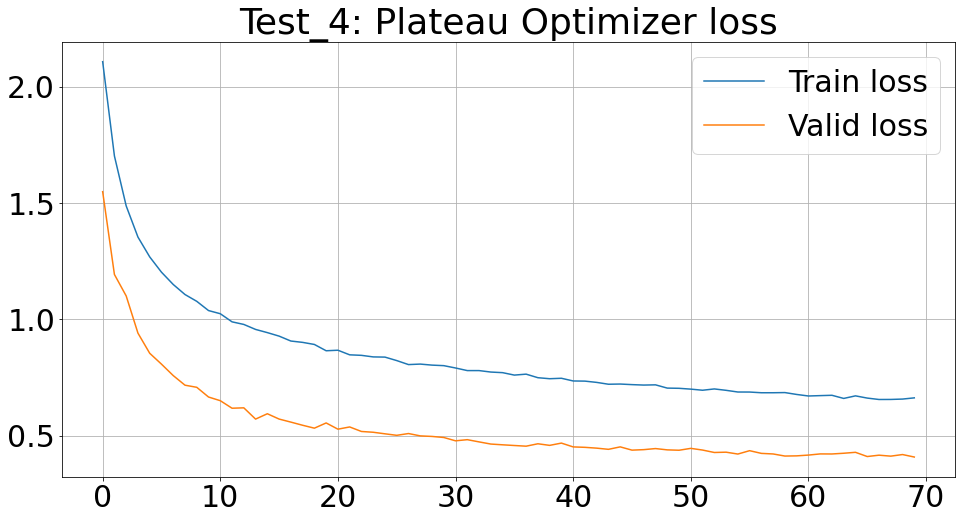

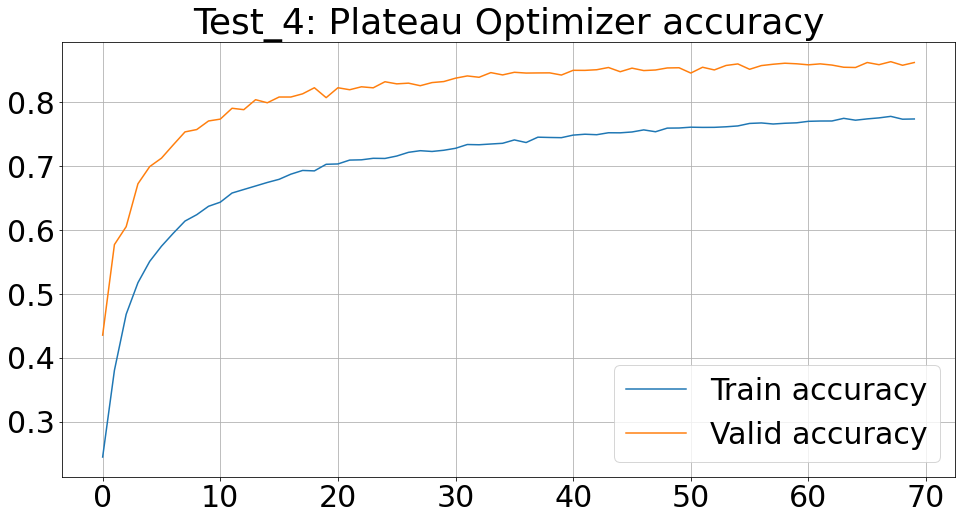

In [84]:
whole_train_valid_cycle_with_plateau_scheduler(
    new_model_4, 70, 'Test_4: Plateau Optimizer')


Кажется, дело не в методах отпимизации лосса, а в самой модели. Возьмем VGG11, и обучим ее на нашем датасете

In [22]:
from vgg import VGG11

In [25]:
model_5 = VGG11()

# Зададим функцию ошибки и оптимизатор
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model_5.parameters(), lr=1e-2)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8)


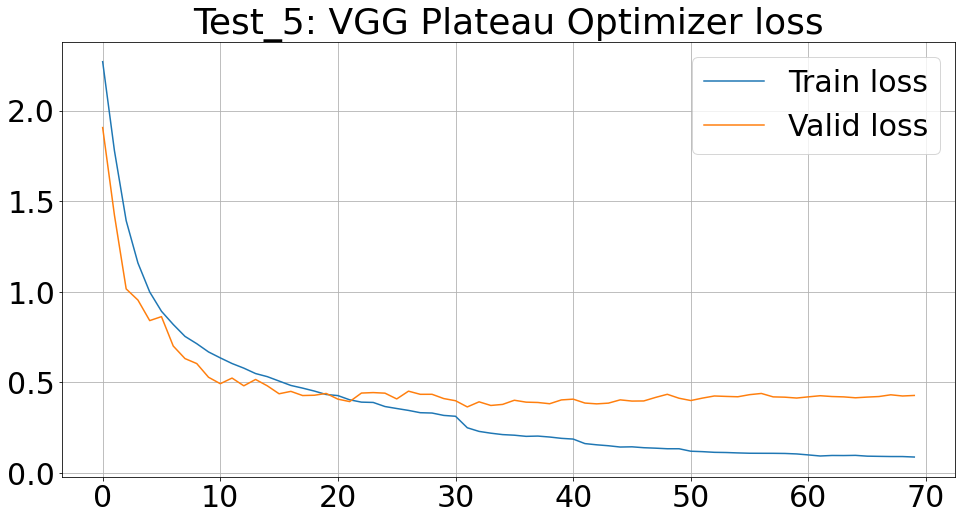

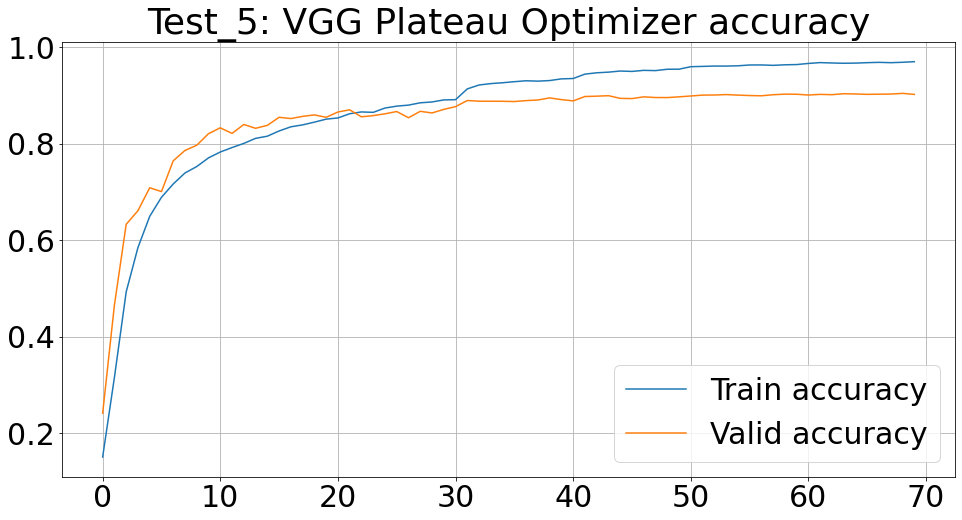

In [26]:
whole_train_valid_cycle_with_plateau_scheduler(
    model_5, 70, 'Test_5: VGG Plateau Optimizer')

In [27]:
evaluate(model_5, test_loader)

Evaluation: 100%|██████████| 79/79 [00:15<00:00,  4.99it/s]


(0.4282297226069849, 0.9022)

Победа!

In [40]:
torch.save(model_5.state_dict(), 'vgg_state_dict')


In [64]:
# чтобы сделать reset параметров:

for layer in new_model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()


In [28]:
preds_tta = predict_tta(model_5, test_loader_tta, device, iterations=4)

In [39]:
# сохраним предсказания на диск
torch.save(preds_tta, 'cifar_advanced.pkl')


In [37]:
y_true = np.array([i[1] for i in test_dataset])

In [38]:
y_true

array([3, 8, 8, ..., 5, 1, 7])

In [44]:
# посчитаем accuracy для 2 подходов
from sklearn.metrics import accuracy_score

preds = predict(model_5, test_loader, device)

Prediction: 100%|██████████| 79/79 [00:17<00:00,  4.43it/s]


In [45]:
no_tta_score = accuracy_score(y_true, preds.cpu().numpy())
tta_score = accuracy_score(y_true, preds_tta.cpu().numpy())

no_tta_score, tta_score


(0.9022, 0.9022)

In [52]:
# перепишем функцию VGG для сдачи

def create_advanced_conv_cifar():
    return nn.Sequential( # 32x32
        nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=True),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2, stride=2), # 16x16

        nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=True),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2, stride=2), # 8x8

        nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=True),
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=True),
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2, stride=2), # 4x4

        nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=True),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=True),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2, stride=2),  # 2x2

        nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=True),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=True),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2, stride=2),  # 1x1

        nn.Flatten(),

        nn.Linear(512, 10)

    )

In [53]:
create_advanced_conv_cifar()


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Conv2d(256, 512, kernel_si